In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4 #size of the hidden unit of a RNN cell
learning_rate = 0.1

The Basic RNN model:

$S_t = tanh ( W . [X_t, S_{t-1}] + b_s)$

$O_t = \sigma (U . S_t + b_o)$

where

$X_t \in R^{n}$ is the input

$S_t \in R^{h}$ is the internal (memory) state

$O_t \in R^{m}$ is the output

$W \in W^{h \times (n + h)}$

$U \in W^{m \times h}$


## Generate sample time series data

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps
    print "batch_partition_length={}, epoch_size={}".format(batch_partition_length,epoch_size)
    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## Constructing RNN

In [4]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

rnn_inputs = tf.one_hot(x, num_classes)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
"""dynamic_rnn dynamically constructs the graph when it is executed. That means graph creation is faster
and you can feed batches of variable size """
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    
logits = tf.reshape(tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
                    [batch_size, num_steps, num_classes])
predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [15]:
"""
Train the network
"""
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print "EPOCH {}".format(idx)
            for step, (X, Y) in enumerate(epoch):
                rnn_inputs, logits_, predictions_, training_loss_, training_state, _ = sess.run([rnn_inputs, logits,
                                                                            predictions,
                                                                           total_loss,
                                                              final_state,
                                                              train_step],
                                                             feed_dict={x:X, y:Y, init_state:training_state})
                
                training_loss += training_loss_
                training_losses.append(training_loss_)
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print "Average loss at step {} for the last 100 steps: {}".format(step, training_loss/100)
                        print "with logits_={} and predictions_={} and training_state={} and X={} and Y={} and rnn_inputs=".format( \
                                                                                                         logits_.shape, \
                                                                                                         predictions_.shape, \
                                                                                                         training_state.shape, \
                                                                                                         X.shape, \
                                                                                                                   Y.shape)
                        print logits_[0]
                        print predictions_[0]
                        print Y[0]
                        print X[0]
                    training_loss = 0

    return training_losses

EPOCH 0
batch_partition_length=5000, epoch_size=500
Average loss at step 100 for the last 100 steps: 0.555459348559
with logits_=(200, 10, 2) and predictions_=(200, 10, 2) and training_state=(200, 4) and X=(200, 10) and Y=(200, 10)
[[ 0.11048448 -0.47342229]
 [-0.97906089  0.09823142]
 [ 0.70985353  0.25790894]
 [ 0.30823103 -0.67959166]
 [-1.7409662   0.52920872]
 [-0.36286911  1.58633578]
 [ 0.4101145  -0.34339517]
 [-0.47655866 -0.3221311 ]
 [ 1.25899684  0.56659651]
 [ 0.08128902 -0.88949561]]
[[ 0.64196587  0.35803413]
 [ 0.25401875  0.74598122]
 [ 0.61110145  0.38889849]
 [ 0.7286576   0.27134237]
 [ 0.09362336  0.9063766 ]
 [ 0.12464008  0.87535989]
 [ 0.67994297  0.32005706]
 [ 0.46146965  0.53853035]
 [ 0.66650069  0.33349931]
 [ 0.72527587  0.27472413]]
[1 0 0 0 0 1 0 0 0 0]
[0 1 1 0 0 0 0 1 0 0]
Average loss at step 200 for the last 100 steps: 0.522970443666
with logits_=(200, 10, 2) and predictions_=(200, 10, 2) and training_state=(200, 4) and X=(200, 10) and Y=(200, 10)
[[

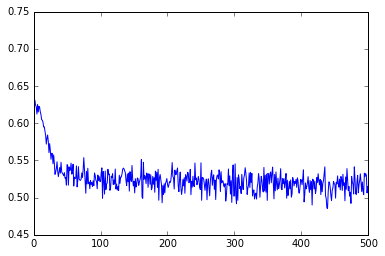

In [16]:
training_losses = train_network(1,num_steps)
plt.plot(training_losses)

In [ ]:
sess = tf.Session()

In [ ]:
x = tf.zeros([2, 3], dtype=np.int32)
sess.run(x)

In [ ]:
x_one_hot = tf.one_hot(x, 2)
sess.run(x_one_hot)

In [ ]:
sess.run(x_one_hot[1])

In [ ]:
input = tf.unstack(x_one_hot, axis=1)
sess.run(input)

In [ ]:
x_one_hot.shape

In [ ]:
y = tf.zeros([2, 3], dtype=np.int32)

In [ ]:
y_as_list = tf.unstack(y, num=3, axis=1)

In [ ]:
sess.run(input[0])

In [ ]:
input[0].shape